In [1]:
import pandas as pd
import nibabel as nib
from nibabel import freesurfer as fs
import neuromaps
from neuromaps.datasets import fetch_atlas, fetch_annotation
from neuromaps import transforms
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import nxviz as nv
import networkx as nx
from networkx import rich_club_coefficient
from nxviz import lines, utils, layouts, nodes, plots, edges, encodings
from random import choice
from nxviz import encodings as aes
from typing import Callable, Dict, Hashable, Tuple, Optional
from matplotlib.colors import ListedColormap, Normalize, BoundaryNorm
from functools import partial
from matplotlib.cm import get_cmap
from sklearn import preprocessing
from matplotlib.colors import LinearSegmentedColormap
from nxviz.geometry import circos_radius, item_theta
from nxviz.polcart import to_cartesian
from nxviz.utils import group_and_sort
from scipy import io

%load_ext rpy2.ipython

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggnewscale)
    library(ggsegGlasser)
    library(ggseg)
    library(glue)
    library(hexbin)
    library(rstatix)
    library(see)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

## Load Glasser parcellation for right hemisphere

In [8]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "../Data/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices
glasser180_right_ctab = glasser180_right_ctab
glasser180_right_names = [name.decode() for name in glasser180_right_names]

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

# Load brain region labels
brain_regions = pd.read_csv("../Results/brain_area_labels.csv", header=None, names=['node', 'Glasser_RH_ROI'])
brain_regions['node_index'] = range(1, brain_regions.shape[0]+1)

## Load overlapping community detection algorithm (OCDA) modules

In [11]:
data_path = "/Users/abry4213/data/OCDA"
num_iters = 100
eval_p = '0.30'
eval_seed = 61

with open(f"{data_path}/OSLOM_results/OSLOM_seed_{eval_seed}_iters_{num_iters}_tol_{eval_p}.txt", 'r') as f:
    oslom_lines = f.readlines()

    # Look for lines beginning with #module 
    module_lines = [line for line in oslom_lines if line.startswith("#module")]

    # Get the number of modules
    num_modules = len(module_lines)

    # Look for non-module lines
    cluster_assignment_lines = [line for line in oslom_lines if not line.startswith("#")]

    # Create a dictionary to store the cluster assignments, with cluster number ranging from 1 to 
    # num_modules as the key and the values being a list of nodes from cluster_assignment_lines
    cluster_assignments_eval = {i: cluster_assignment_lines[i].split() for i in range(num_modules)}

    # Convert the dictionary to a pandas dataframe, with one row per item in each value
    oslom_modules = (pd.DataFrame([(key, node) for key, nodes in cluster_assignments_eval.items() for node in nodes], columns=['module', 'node'])
                            .assign(p_threshold=eval_p, num_iters=num_iters, seed_num=eval_seed)
                            .assign(node = lambda x: x['node'].astype(int)))

    oslom_overlapping_nodes = oslom_modules.groupby('node').agg({'module': 'nunique'}).query("module > 1").index.values

    # Convert overlapping nodes to integers
    oslom_overlapping_nodes = [int(node) for node in oslom_overlapping_nodes]

oslom_modules_final_glasser180_right_long = (oslom_modules
 .assign(node = lambda x: x['node'].astype(int))
 .merge(brain_regions.drop(columns=['node']), left_on='node', right_on='node_index', how='left')
 .filter(['node', 'Glasser_RH_ROI', 'module'], axis=1)
)

oslom_modules_final_glasser180_right_long.sort_values('node').to_csv("../Results/OSLOM30_final_module_assignments_with_duplicates.csv", index=False)
oslom_modules_final_glasser180_right = pd.read_csv(f"{data_path}/OSLOM30_final_module_assignments.csv")

# Load overlapping ndoe orders
module_orders = pd.read_csv(f"{data_path}/module_orders_OSLOM30.csv")

# How many overlapping nodes are there?
num_overlapping_nodes = len(oslom_overlapping_nodes)

In [10]:
# What value of node is missing between 1 and 180?
missing_node = set(range(1, 181)).difference(oslom_modules_final_glasser180_right['node'].unique())

# Node 92 is missing from the final module assignments (R_13l_ROI)

## View overlapping community detection modules in the brain

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


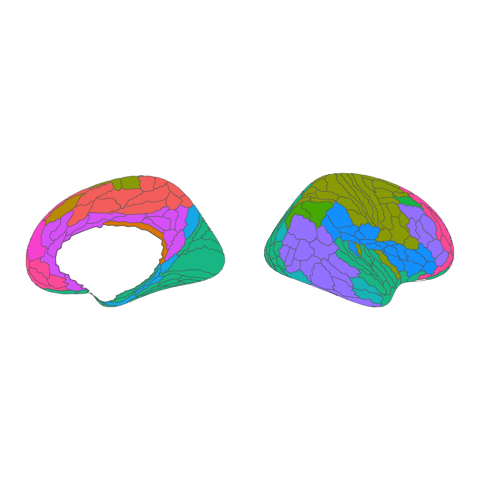

In [7]:
%%R -i oslom_modules_final_glasser180_right

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

# Tidy data
oslom_modules_final_glasser180_right <- oslom_modules_final_glasser180_right %>% 
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "R_", "rh_R_")) %>%
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "_ROI", ""))%>% 
  dplyr::rename("label" = "Glasser_RH_ROI")

# Merge modules + Glasser data
modules_in_glasser_atlas <- oslom_modules_final_glasser180_right %>% 
  left_join(., glasser_lookup_table) %>%
  arrange(module)

# Plot modules on cortical surface with Glasser parcellation
modules_in_glasser_atlas %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=module),
             hemi = "right") +
  theme_void()  + 
  scale_fill_discrete(na.translate = F) +
  labs(fill = "Community Detection Module") +
  theme(legend.position="none")
# ggsave("../Plots/all_overlapping_CD_modules_together.svg", width=4, height=2.5, units="in", dpi=300)

In [38]:
%%R -i oslom_modules_final_glasser180_right,oslom_modules_final_glasser180_right_long,module_orders

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

# plot_colors <- viridis::viridis(14)
plot_colors <- gg_color_hue(14)

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

# Tidy data
oslom_modules_final_glasser180_right_long <- oslom_modules_final_glasser180_right_long %>% 
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "R_", "rh_R_")) %>%
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "_ROI", ""))%>% 
  dplyr::rename("label" = "Glasser_RH_ROI")

# Merge modules + Glasser data
modules_in_glasser_atlas <- oslom_modules_final_glasser180_right_long %>% 
  left_join(., glasser_lookup_table) %>%
  mutate(module = as.character(module)) %>%
  arrange(module)

for (module_num in 1:length(module_orders$Module_Number)) {
  this_module <- module_orders$Module_Number[module_num]
  plot_color <- plot_colors[module_num]

  print(this_module)

  main_module_data <- modules_in_glasser_atlas %>%
      filter(module == this_module)

  if (nrow(main_module_data) > 0) {
    main_module_data %>%
      ggplot() +
      geom_brain(atlas=glasser, mapping=aes(fill=module),
                 hemi = "right") +
      theme_void()  + 
      scale_fill_manual(values=c(plot_color), na.value="white") +
      labs(fill = "Community Detection Module") +
      ggtitle(glue("Module {this_module}")) +
      theme(legend.position="none", plot.title = element_text(hjust = 0.5))
    
    ggsave(glue("../Plots/OSLOM30_brain_module_{this_module}.svg"), width=4, height=2.5, units="in", dpi=300)
  }  

  else {
    # Overlapping module
    oslom_modules_final_glasser180_right %>%
      filter(module == this_module)  %>%  
      mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "R_", "rh_R_")) %>%
      mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "_ROI", "")) %>% 
      dplyr::rename("label" = "Glasser_RH_ROI") %>%
      left_join(., glasser_lookup_table) %>%
      mutate(module = as.character(module)) %>%
      ggplot() +
      geom_brain(atlas=glasser, mapping=aes(fill=module),
                 hemi = "right") +
      theme_void()  + 
      scale_fill_manual(values=c(plot_color), na.value="white") +
      labs(fill = "Community Detection Module") +
      ggtitle(glue("Module {this_module}")) +
      theme(legend.position="none", plot.title = element_text(hjust = 0.5))
    
    ggsave(glue("../Plots/OSLOM30_brain_module_{this_module}.svg"), width=4, height=2.5, units="in", dpi=300)
  }
}


Joining with `by = join_by(label)`
[1] "0"
[1] "5"
[1] "2_5"
Joining with `by = join_by(label)`
[1] "0_2_5"
Joining with `by = join_by(label)`
[1] "2"
[1] "2_4"
Joining with `by = join_by(label)`
[1] "4"
[1] "1_4"
Joining with `by = join_by(label)`
[1] "1"
[1] "3"
[1] "1_6"
Joining with `by = join_by(label)`
[1] "6"
[1] "0_6"
Joining with `by = join_by(label)`
[1] "5_6"
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'
merging atlas and dat

## Merge all the data!

In [9]:
# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(glasser180_right_df, oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left')

# Drop rows where Glasser_RH_ROI is '???'
merged_df = merged_df.query('Glasser_RH_ROI != "???"')

### How many vertices are in each overlapping brain region?

In [60]:
overlapping_vertex_counts = (merged_df
                            #  .query("overlapping=='overlapping'")
                             .groupby(["Glasser_RH_ROI", 'overlapping'])
                             .size()
                             .reset_index(name="vertex_count")
                             .sort_values("vertex_count", ascending=False))

In [59]:
%%R -i overlapping_vertex_counts,oslom_modules_final_glasser180_right,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Name)

overlapping_vertex_counts %>% 
    left_join(., oslom_modules_final_glasser180_right) %>% 
    mutate(Glasser_RH_ROI = gsub("R_|_ROI", "", Glasser_RH_ROI)) %>%
    mutate(Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, vertex_count)) %>%
    left_join(., module_orders, by=c("module"="Module_Number")) %>%
    ggplot(mapping=aes(x=Glasser_RH_ROI, y=vertex_count, fill=Module_Name)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_hline(yintercept=c(1000, 2000), linetype=2) +
    geom_bar(stat="identity") +
    ylab("# Vertices") +
    xlab("Brain Region") +
    coord_flip() + 
    scale_fill_manual(values=colormap) +
    geom_text(aes(label=vertex_count), hjust=0) +
    theme(legend.position="none")
ggsave(glue("../Plots/OSLOM30_overlapping_region_vertex_counts.svg"), width=3.5, height=4.25, units="in", dpi=300)

Joining with `by = join_by(Glasser_RH_ROI)`


In [70]:
%%R -i overlapping_vertex_counts,oslom_modules_final_glasser180_right,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Name)

overlapping_vertex_counts %>% 
    left_join(., oslom_modules_final_glasser180_right) %>% 
    mutate(Glasser_RH_ROI = gsub("R_|_ROI", "", Glasser_RH_ROI)) %>%
    mutate(Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, vertex_count)) %>%
    left_join(., module_orders, by=c("module"="Module_Number")) %>%
    ggplot(mapping=aes(x=overlapping, y=vertex_count, color=Module_Name)) +
    geom_point() +
    geom_violinhalf(aes(fill=overlapping), scale="width", color="black", position = position_dodge(width = 1), width=0.9)  +
    geom_point(position = position_jitter(width = 0.1, height=0), alpha=0.8, stroke=0, size=2) +
    scale_fill_manual(values=c("overlapping"="#9e4aca", "non-overlapping" = "#e7ece5")) +
    scale_color_manual(values=colormap) +
    ylab("Number of Vertices") +
    xlab("Node type") +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.5, linewidth=0.28, 
            show.legend=FALSE, position = position_dodge(width=3)) +
    theme(legend.position='none')
ggsave(glue("../Plots/OSLOM30_overlapping_region_vertex_counts_violins.svg"), width=3.5, height=4, units="in", dpi=300)

Joining with `by = join_by(Glasser_RH_ROI, overlapping)`


In [72]:
%%R -i overlapping_vertex_counts,oslom_modules_final_glasser180_right,module_orders

overlapping_vertex_counts %>% 
    left_join(., oslom_modules_final_glasser180_right) %>% 
    mutate(Glasser_RH_ROI = gsub("R_|_ROI", "", Glasser_RH_ROI)) %>%
    mutate(Glasser_RH_ROI = fct_reorder(Glasser_RH_ROI, vertex_count)) %>%
    left_join(., module_orders, by=c("module"="Module_Number")) %>% 
    wilcox_test(vertex_count ~ overlapping)

Joining with `by = join_by(Glasser_RH_ROI, overlapping)`
# A tibble: 1 × 7
  .y.          group1          group2         n1    n2 statistic      p
* <chr>        <chr>           <chr>       <int> <int>     <dbl>  <dbl>
1 vertex_count non-overlapping overlapping   164    15      802. 0.0262


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: `...` must be empty in `format.tbl()`
Caused by error in `format_tbl()`:
! `...` must be empty.
✖ Problematic argument:
• useS4 = FALSE 



## Visualize connectivity data between overlapping modules and the 6 structural networks

In [3]:
# Load in connectivity data
RH_connectivity_data = pd.DataFrame(scipy.io.loadmat('../Results/RH.mat')['RH'])

region_labels = pd.read_csv("../Results/brain_area_labels.csv", header=None)
region_labels.columns = ["region_index", "Glasser_RH_ROI"]
# RH_connectivity_data.columns = region_labels.Glasser_RH_ROI[0:180]


In [69]:
%%R -i region_labels,RH_connectivity_data,oslom_modules_final_glasser180_right -o RH_connectivity_data_tidy

regions_included <- oslom_modules_final_glasser180_right$Glasser_RH_ROI

region_labels_tidy <- region_labels %>%
    pull(Glasser_RH_ROI)

RH_connectivity_data_tidy <- RH_connectivity_data
colnames(RH_connectivity_data_tidy) <- rownames(RH_connectivity_data_tidy) <- region_labels_tidy[1:180]

module_order_for_connectogram <- c("2_5",  "0_2_5", "2_4", "1_4", "1_6", "0_6",
                                   "5_6", "0", "5", "2", "4", "1", "3", "6")

region_order_for_connectogram <- c("R_POS2_ROI", "R_PreS_ROI", "R_ProS_ROI", "R_PeEc_ROI", 
                                   "R_PHA1_ROI", "R_RSC_ROI", "R_TE1a_ROI", "R_PH_ROI",
                                   "R_PGp_ROI", "R_STSva_ROI", "R_PFm_ROI", "R_PGs_ROI",
                                   "R_8Av_ROI", "R_8BM_ROI", "R_9m_ROI", 
                                   oslom_modules_final_glasser180_right %>% 
                                        filter(overlapping=="non-overlapping") %>%
                                        mutate(module = factor(module, levels=module_orders$Module_Number)) %>% 
                                        arrange(module) %>% 
                                        pull(Glasser_RH_ROI))

RH_connectivity_data_tidy <- RH_connectivity_data_tidy %>%
    rownames_to_column(var="region_from") %>%
    pivot_longer(-region_from, names_to="region_to", values_to="SC") %>% 
    filter(region_from != region_to) %>% 
    left_join(., oslom_modules_final_glasser180_right %>% dplyr::select(-node), by=c("region_from"="Glasser_RH_ROI")) %>%
    dplyr::rename("module_from" = "module", "overlapping_from" = "overlapping") %>%
    left_join(., oslom_modules_final_glasser180_right %>% dplyr::select(-node), by=c("region_to"="Glasser_RH_ROI")) %>%
    dplyr::rename("module_to" = "module", "overlapping_to" = "overlapping")  %>%
    filter(overlapping_from=="overlapping", region_from %in% regions_included, region_to %in% regions_included) %>%
    mutate(overlapping_to = factor(overlapping_to, levels=c("overlapping", "non-overlapping")),
           module_from = factor(module_from, levels=module_order_for_connectogram),
           module_to = factor(module_to, levels=module_order_for_connectogram),
           region_to = factor(region_to, levels=region_order_for_connectogram)) %>%
    arrange(overlapping_to, region_to) %>% 
    mutate(module_to_num = as.numeric(factor(module_to, levels = module_order_for_connectogram)))

In [ ]:
nodes_list = RH_connectivity_data_tidy.region_to.unique()

In [145]:
# Function to color nodes by group
def group_colormap(data: pd.Series):
    # cmap = {"Visual + cingulate and adj. cortex": "#f8766d", 
    #         "Attention + visual + cingulate and adj. cortex": "#de8c00", 
    #         "Cingulate and adj. cortex": "#b79f00",
    #         "Cingulate and adj. cortex + visual": "#7cae00",
    #         "Visual": "#00ba38",
    #         "Visual + fronto-parietal": "#00c08b",
    #         "Fronto-parietal": "#00bfc4", 
    #         "Fronto-parietal + somatomotor": "#00b4f0",
    #         "Somatomotor": "#619cff",
    #         "Somatomotor + insula and post. temporal": "#c77cff",
    #         "Insula and post. temporal": "#f564e3",
    #         "Insula and post. temporal + visual": "#ff64b0"}

    cmap = {1: "#de8c00", 
            2: "#7cae00", 
            3: "#00c08b",
            4: "#00b4f0",
            5: "#c77cff",
            6: "#ff64b0",
            7: "#f8766d", 
            8: "#b79f00",
            9: "#00ba38",
            10: "#00bfc4",
            11: "#619cff",
            12: "#f564e3"}
    return data.apply(lambda x: cmap.get(x))
    
# Custom edge coloring functions
def continuous_color_func(val, cmap, data: pd.Series, vmin, vmax):
    """Return RGBA of a value.

    ## Parameters

    - `val`: Value to convert to RGBA
    - `cmap`: A Matplotlib cmap
    - `data`: Pandas series.
    """
    norm = Normalize(vmin=vmin, vmax=vmax)
    return cmap(norm(val))

def color_func(data: pd.Series, cmap, vmin, vmax) -> Callable:
    """Return a color function that takes in a value and returns an RGB(A) tuple.

    This will do the mapping to the continuous and discrete color functions.
    """
    func = continuous_color_func
    return partial(func, cmap=cmap, data=data, vmin=vmin, vmax=vmax)

def data_color(data: pd.Series, ref_data: pd.Series, cmap, vmin, vmax) -> pd.Series:
    """Return iterable of colors for a given data.

    `cfunc` gives users the ability to customize the color mapping of a node.
    The only thing that we expect is that it takes in a value
    and returns a matplotlib-compatible RGB(A) tuple or hexadecimal value.

    The function takes in `ref_data`
    which is used to determine important colormap values (such as boundaries).
    That colormap is then applied to the actual `data`.

    ## Parameters

    - `data`: The data on which to map colors.
    - `ref_data`: The data on which the colormap is constructed.
    """
    cfunc = color_func(ref_data, cmap, vmin, vmax)
    return data.apply(cfunc)

def edge_colors_cat(
    et: pd.DataFrame,
    nt: pd.DataFrame,
    cmap,
    color_by: Hashable,
    node_color_by: Hashable,
):
    """Default edge line color function."""
    if color_by in ("source_node_color", "target_node_color"):
        edge_select_by = color_by.split("_")[0]
        return data_color(
            et[edge_select_by].apply(nt[node_color_by].get),
            nt[node_color_by], cmap=cmap, vmin=1, vmax=1)
    elif color_by:
        return data_color(et[color_by], et[color_by], cmap=cmap, vmin=1, vmax=1)
    return pd.Series(["black"] * len(et), name="color_by")

def edge_colors(
    et: pd.DataFrame,
    nt: pd.DataFrame,
    cmap,
    vmin,
    vmax,
    color_by: Hashable,
    node_color_by: Hashable,
):
    """Default edge line color function."""
    if color_by in ("source_node_color", "target_node_color"):
        edge_select_by = color_by.split("_")[0]
        return data_color(
            et[edge_select_by].apply(nt[node_color_by].get),
            nt[node_color_by], cmap=cmap, vmin=vmin, vmax=vmax)
    elif color_by:
        return data_color(et[color_by], et[color_by], cmap=cmap, vmin=vmin, vmax=vmax)
    return pd.Series(["black"] * len(et), name="color_by")

# Define a formatting function to add a minus sign to the hypo-connectivity labels
def format_func(value):
    return f'-{value:.1f}'

def plot_individual_chord_graph(G, my_cmap, group_var, vmin, vmax, group_colormap, alpha_max=0.7, lw_max=1, split_by_overlapping=True):
    # Customize node styling
    ax = plt.gca()

    nt = utils.node_table(G)
    # pos = layouts.circos(nt, group_by=group_var, sort_by=group_var)
    
    nodes_list = list(nt.index)
    radius = circos_radius(len(nodes_list))
    pos = {} 
    if split_by_overlapping:
        for i in range(15):
            node = nt.index[i]
            # theta = i * 2 * np.pi / len(nodes_list)
            theta = i * 12.6 * np.pi / len(nodes_list)
            x, y = to_cartesian(r=radius, theta=theta+0.015)
            pos[node] = np.array([x, y])
        for i in np.arange(15, len(nodes_list)):
            node = nt.index[i]
            theta = i * 1.05 * np.pi / len(nodes_list)
            x, y = to_cartesian(r=radius, theta=theta+2.95)
            pos[node] = np.array([x, y])
    else:
        for i, node in enumerate(nt.index):
            theta = i * 2 * np.pi / len(nodes_list)
            x, y = to_cartesian(r=radius, theta=theta)
            pos[node] = np.array([x, y])

    # Define nodes and corresponding lobe colors
    node_color = group_colormap(nt[group_var])
    alpha = nodes.transparency(nt, alpha_by=None)
    size = nodes.node_size(nt, size_by=None)
    patches = nodes.node_glyphs(
        nt, pos, node_color=node_color, alpha=alpha, size=size)
    for patch in patches:
        ax.add_patch(patch)
        
    # Customize edge styling
    et = utils.edge_table(G)
    # edge_color = group_colormap(nt[group_var])
    edge_color = edge_colors(et, nt=None, color_by="weight", node_color_by=None, cmap=my_cmap, vmin=vmin, vmax=vmax)
    lw = pd.Series([2]*et.shape[0])
    edge_alpha = pd.Series(preprocessing.minmax_scale(np.absolute(et["weight"]), feature_range=(0.1, alpha_max), axis=0, copy=True))
    edge_lw = pd.Series(preprocessing.minmax_scale(np.absolute(et["weight"]), feature_range=(0.1, lw_max), axis=0, copy=True))
    patches = lines.circos(
        et, pos, edge_color=edge_color, alpha=edge_alpha, lw=edge_lw, aes_kw={"fc": "none"}
    )
    for patch in patches:
        ax.add_patch(patch)
        
    plots.rescale(G)
    plots.aspect_equal()
    plots.despine()


/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_96333/2367326055.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  module_to_num = RH_connectivity_data_tidy.query("region_to == @brain_region")["module_to_num"][0]
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_96333/2367326055.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  module_to_num = RH_connectivity_data_tidy.query("region_to == @brain_region")["module_to_num"][0]
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_96333/2367326055.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

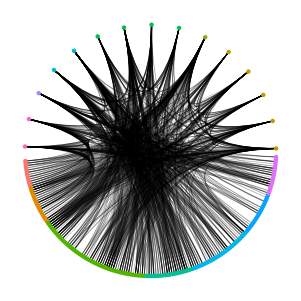

In [147]:
G_SC = nx.DiGraph(name = "Structural Connectivity")
RH_connectivity_data_array = RH_connectivity_data_tidy.filter(["region_from", "region_to", "SC", "module_from"], axis=1).to_numpy()

# Add all nodes
nodes_list = RH_connectivity_data_tidy.region_to.unique()
G_SC.add_nodes_from(nodes_list)

for i in range(len(RH_connectivity_data_array)):
    connection = RH_connectivity_data_array[i]
    region_from = connection[0] # protein a node
    region_to = connection[1] # protein b node
    SC_value = connection[2] # score as weighted edge
    module_from = connection[3]
    
    # Add only high edges to G_hyper
    if SC_value > 0:
        G_SC.add_weighted_edges_from([(region_from,region_to,SC_value)])

# Add module to each node (region)
for n, d in G_SC.nodes(data=True):
    brain_region = n
    module_to_num = RH_connectivity_data_tidy.query("region_to == @brain_region")["module_to_num"][0]
    G_SC.nodes[n]["module_to_num"] = module_to_num

# Figure out edge color ranges to match
G_SC_et = utils.edge_table(G_SC)

# Figure out edge color ranges to match
vmin = G_SC_et.weight.min()
vmax = G_SC_et.weight.max()
a = np.array([[vmin,vmax]])

# Hyper plot
fig_SC, ax_SC = plt.subplots()

# Define my own LinearSegmentedColormap with just the color black
black_cmap = LinearSegmentedColormap('black', {'red':   ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0)),
                                               'green': ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0)),
                                               'blue':  ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0))})
 
#
plot_individual_chord_graph(G_SC, black_cmap, group_var="module_to_num", alpha_max=0.6, group_colormap=group_colormap, vmin=vmin, vmax=vmax, split_by_overlapping=True)
fig_SC.tight_layout()
fig_SC.set_size_inches(3,3)
fig_SC.savefig("../Plots/SC_connectogram.svg", dpi=300)


### What is the connectivity between only the eleven overlapping nodes?

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_96333/1911530000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  module_to_num = RH_connectivity_data_overlapping.query("region_to == @brain_region")["module_to_num"][0]
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_96333/1911530000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  module_to_num = RH_connectivity_data_overlapping.query("region_to == @brain_region")["module_to_num"][0]
/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_96333/1911530000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

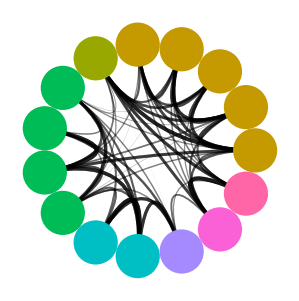

In [151]:
G_SC = nx.DiGraph(name = "Structural Connectivity")
RH_connectivity_data_overlapping = RH_connectivity_data_tidy.query("overlapping_from=='overlapping' & overlapping_to=='overlapping'")
RH_connectivity_data_array = RH_connectivity_data_overlapping.filter(["region_from", "region_to", "SC", "module_from"], axis=1).to_numpy()

# Add all nodes
nodes_list = RH_connectivity_data_overlapping.region_to.unique()
G_SC.add_nodes_from(nodes_list)

for i in range(len(RH_connectivity_data_array)):
    connection = RH_connectivity_data_array[i]
    region_from = connection[0] # protein a node
    region_to = connection[1] # protein b node
    SC_value = connection[2] # score as weighted edge
    module_from = connection[3]
    
    # Add only high edges to G_hyper
    if SC_value > 0:
        G_SC.add_weighted_edges_from([(region_from,region_to,SC_value)])

# Add module to each node (region)
for n, d in G_SC.nodes(data=True):
    brain_region = n
    module_to_num = RH_connectivity_data_overlapping.query("region_to == @brain_region")["module_to_num"][0]
    G_SC.nodes[n]["module_to_num"] = module_to_num

# Figure out edge color ranges to match
G_SC_et = utils.edge_table(G_SC)

# Figure out edge color ranges to match
vmin = G_SC_et.weight.min()
vmax = G_SC_et.weight.max()
a = np.array([[vmin,vmax]])

# Hyper plot
fig_SC, ax_SC = plt.subplots()

# Define my own LinearSegmentedColormap with just the color black
black_cmap = LinearSegmentedColormap('black', {'red':   ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0)),
                                               'green': ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0)),
                                               'blue':  ((0.0, 0.0, 0.0), 
                                                        (1.0, 0.0, 0.0))})
 
#
plot_individual_chord_graph(G_SC, black_cmap, group_var="module_to_num", vmin=vmin, vmax=vmax, lw_max=3, group_colormap=group_colormap, split_by_overlapping=False)
fig_SC.tight_layout()
fig_SC.set_size_inches(3,3)
fig_SC.savefig("../Plots/SC_connectogram_overlapping.svg", dpi=300)
